In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
import prodimopy.plot as pplot
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve
from scipy.optimize import minimize

In [2]:
def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise

In [3]:
cmap = mpl.colormaps.get_cmap('tab20')

In [4]:
with open('FLiTsData100.pkl', 'rb') as f:
    df = pickle.load(f)

10657


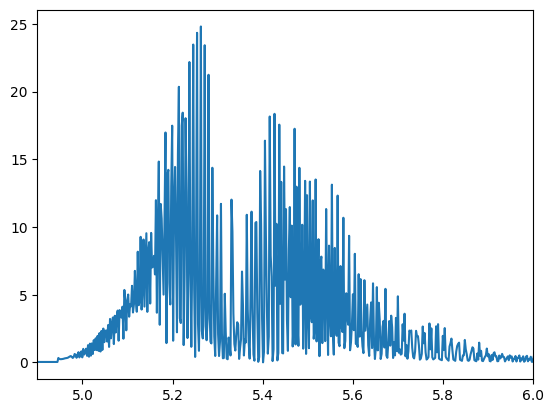

In [5]:
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
new_wl = np.linspace(4.9, 27.5, 10657)
total = np.zeros(len(new_wl))
for i, row in df.iterrows():
    wl = row['FLiTs Wavelength']
    flux = row['FLiTs Flux'] + row['FLiTs Flux Continuum']
    flux = add_noise(flux, SNR=30000)-row['FLiTs Flux Continuum']
    NO_flux = row['FLiTs NO Flux']
    NO_wl = row['FLiTs NO Wavelength']
    NO_flux = np.interp(new_wl, NO_wl, NO_flux)
    # flux_without_NO = flux - NO_flux
    # mask = (wl > 30) | (wl < 4)
    # flux[mask] = 0
    # flux_without_NO[mask] = 0
    # NO_flux[mask] = 0
    # cc1 = fftconvolve(NO_flux, flux_without_NO[::-1], mode='full')
    # cc2 = fftconvolve(NO_flux, flux[::-1])
    # lags = np.arange(-len(flux) + 1, len(NO_flux))
    # plt.plot(lags, cc1, label='Without NO')
    # plt.plot(lags, cc2, label='With NO')
    # plt.legend()
    # plt.xlim(-100000, 100000)
    # plt.show()
    total += NO_flux/max(NO_flux)
plt.plot(new_wl, total)
plt.xlim(4.9, 6)
print(len(NO_flux))
plt.show()


In [6]:
# species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
# for specie in species:
#     for i, row in df.iterrows():
#         # if i != 20:
#         #     continue
#         wl = row[f'FLiTs {specie} Wavelength']
#         flux = row[f'FLiTs {specie} Flux']
#         plt.plot(wl, flux)
#     plt.title(specie)
#     plt.xlabel('Wavelength (um)')
#     plt.ylabel('Flux (Jy)')
#     # plt.xlim(4.5, 28.9)
#     plt.show()

In [11]:
def difference(params):
    a,b = params
    total = 0
    for i, row in df.iterrows():
        wl = row['FLiTs Wavelength']
        flux = row['FLiTs Flux'] + row['FLiTs Flux Continuum']
        flux = add_noise(flux, SNR=300)-row['FLiTs Flux Continuum']
        NO_flux = row['FLiTs NH3 Flux']
        NO_wl = row['FLiTs NH3 Wavelength']
        NO_flux = np.interp(wl, NO_wl, NO_flux)
        flux_without_NO = flux
        flux += NO_flux
        mask = (wl > b) | (wl < a)
        flux[mask] = 0
        flux_without_NO[mask] = 0
        NO_flux[mask] = 0
        cc1 = fftconvolve(NO_flux, flux_without_NO[::-1], mode='full')
        cc2 = fftconvolve(NO_flux, flux[::-1])
        lags = np.arange(-len(flux) + 1, len(NO_flux))
        total -= abs(cc2[lags==0]-cc1[lags==0])/abs(b-a+1)
    return total

initial_guess = [6, 6.5]

result = minimize(difference, initial_guess, method='Nelder-Mead')

best_params = result.x
print(best_params)

[6.  6.5]


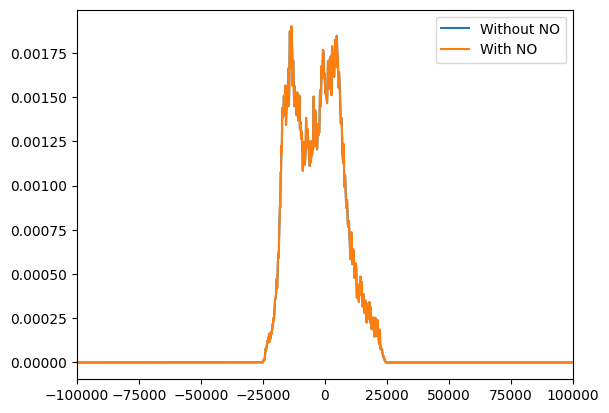

In [10]:
wl = row['FLiTs Wavelength']
flux = row['FLiTs Flux'] + row['FLiTs Flux Continuum']
flux = add_noise(flux, SNR=300)-row['FLiTs Flux Continuum']
NO_flux = row['FLiTs NH3 Flux']
NO_wl = row['FLiTs NH3 Wavelength']
NO_flux = np.interp(wl, NO_wl, NO_flux)
flux_without_NO = flux
flux += NO_flux
# mask = (wl > b) | (wl < a)
mask = (wl > best_params[1]) | (wl < best_params[0])
flux[mask] = 0
flux_without_NO[mask] = 0
NO_flux[mask] = 0
cc1 = fftconvolve(NO_flux, flux_without_NO[::-1], mode='full')
cc2 = fftconvolve(NO_flux, flux[::-1])
lags = np.arange(-len(flux) + 1, len(NO_flux))
plt.plot(lags, cc1, label='Without NO')
plt.plot(lags, cc2, label='With NO')
plt.legend()
plt.xlim(-100000, 100000)
plt.show()